In [1]:
import numpy as np
import scanpy as sc
import cinemaot as co
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

from metrics import calculate_metrics

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/benchmark/metrics.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [2]:
from scCAPE import sccape
from scCAPE import plotting
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import pickle
import gseapy as gp
from fractions import Fraction
import scipy
from scipy.sparse import csr_matrix

In [3]:
import pertpy as pt
import scanpy as sc
from scvi import REGISTRY_KEYS

In [4]:
import os
import sklearn
import scipy
from sklearn.neighbors import NearestNeighbors

AnnData object with n_obs × n_vars = 40603 × 2000
    obs: 'nGene', 'nUMI', 'Cluster', 'Batch', 'CellType', 'Perturbation', 'isKey', 'isAnalysed', 'SCRUBLET', 'perturb01'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'CellType_colors', 'Perturbation_colors', 'hvg', 'neighbors', 'pca', 'perturb01_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 40603 × 2000
    obs: 'nGene', 'nUMI', 'Cluster', 'Batch', 'CellType', 'Perturbation', 'isKey', 'isAnalysed', 'SCRUBLET', 'perturb01'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'CellType_colors', 'Perturbation_colors', 'hvg', 'neighbors', 'pca', 'perturb01_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


perturb01 nan mutated CellType


Effect modifier (called confounder in this paper) space:


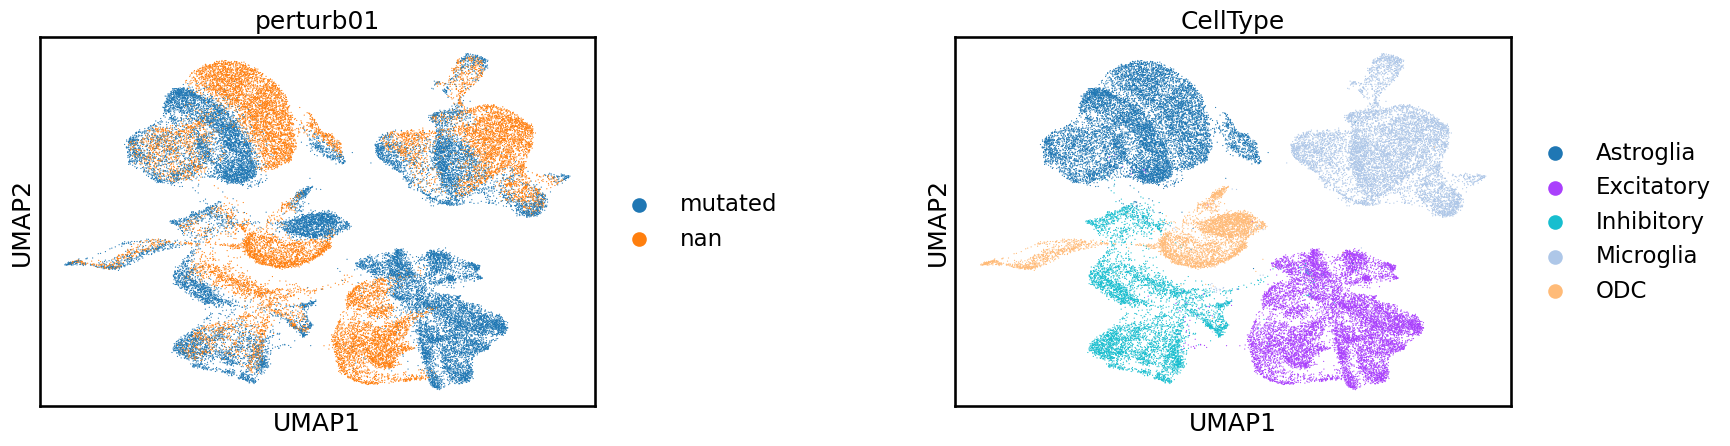

LISI---


cLISI, bLISI, LISI_F1 0.9958631497379129 0.1440160741583977 0.25164122341669604


ASW---


asw_label 0.5506751090288162


asw_batch 0.6858293637570642


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


kbet_score 0.44171832299754765
graph_conn 0.9992355395904038


NMI, ARI ---
NMI 0.9659880003542185
ARI 0.9808844155988334
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
cf   0.550675  0.980884  0.965988  0.995863  0.144016   0.685829   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.441718            0.999236   0.851827  0.991528       0.264907   

     F1 LISI  
cf  0.251641  


In [5]:
def run_cinema_ot(adata, condition_key, cell_type_key,exp_label,ref_label, dataset_name):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]]
    
    adata_=adata.copy()
    print(adata_)
    sc.pp.pca(adata_)
    print(condition_key,ref_label,exp_label,cell_type_key)
    cf, ot, de = co.cinemaot.cinemaot_unweighted(adata_, obs_label=condition_key, ref_label=ref_label,
                                                 expr_label=exp_label, mode='parametric', thres=0.5,
                                                 smoothness=1e-5, eps=1e-3, preweight_label=cell_type_key)
    de.write("./cinema_ot/"+dataset_name+"_ITE.h5ad")
    adata_.obsm['cf'] = cf.copy()
    adata_.obsm['cf'][adata_.obs[condition_key]==ref_label,:] = np.matmul(ot/np.sum(ot,axis=1)[:,None],cf[adata_.obs[condition_key]==exp_label,:])
    sc.pp.neighbors(adata_, use_rep='cf')

    sc.tl.umap(adata_, random_state=1)
    print("Effect modifier (called confounder in this paper) space:")
    sc.pl.umap(adata_, color=[condition_key, cell_type_key], wspace=0.5)

    import rpy2.robjects as robjects
    import os
    os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
    import anndata2ri
    anndata2ri.activate()

    from metrics import calculate_metrics

    adata_.write("./cinema_ot/"+dataset_name+".h5ad")
    
    try:
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='cf', savepath="./cinema_ot/"+dataset_name+".csv")
    except:
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='cf', savepath="./cinema_ot/"+dataset_name+".csv")

adata=sc.read_h5ad("../data/ASD1.h5ad")
run_cinema_ot(adata=adata, condition_key='perturb01', cell_type_key="CellType", exp_label='mutated', ref_label='nan', dataset_name="ASD1")

AnnData object with n_obs × n_vars = 40603 × 2000
    obs: 'nGene', 'nUMI', 'Cluster', 'Batch', 'CellType', 'Perturbation', 'isKey', 'isAnalysed', 'SCRUBLET', 'perturb01'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'CellType_colors', 'Perturbation_colors', 'hvg', 'neighbors', 'pca', 'perturb01_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


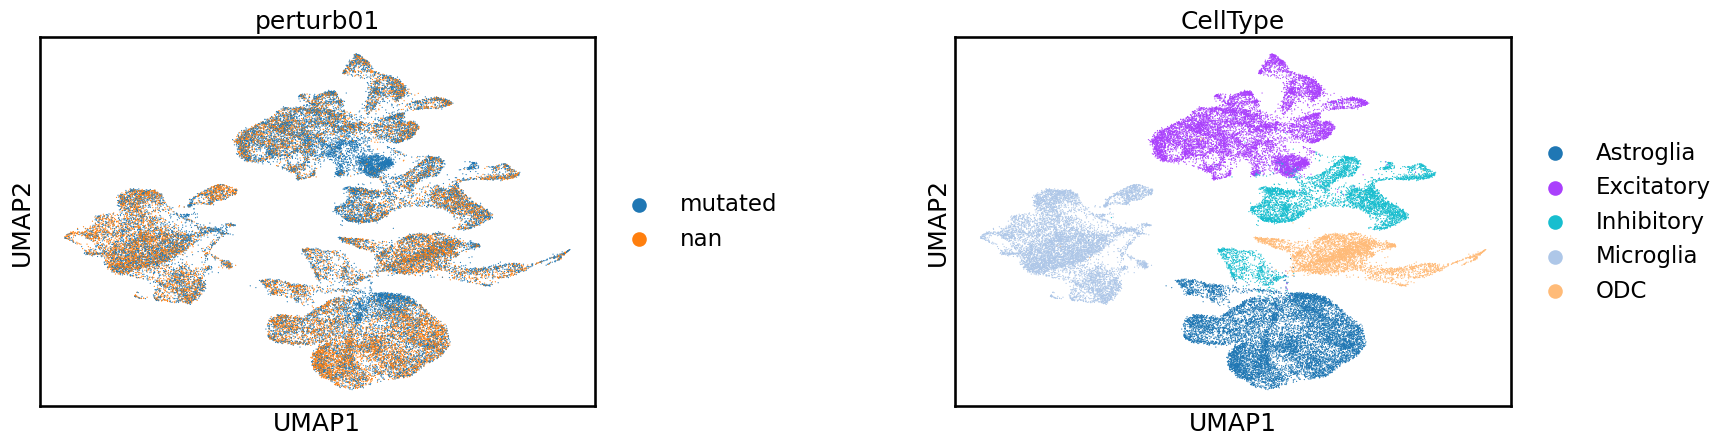

LISI---


cLISI, bLISI, LISI_F1 0.9945344149217002 0.09613234847651307 0.1753183138161347


Variance contribution increased after integration!
Setting PCR comparison score to 0.
ASW---


asw_label 0.6733586341142654


asw_batch 0.8477484113372904


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 4


kbet_score 0.21252080829279607
graph_conn 0.9994726166291381


NMI, ARI ---
NMI 0.9177980626217841
ARI 0.9002000173247925
positive and true positive rate---


    ASW_label     ARI       NMI   1-cLISI     bLISI  ASW_batch  \
ef   0.673359  0.9002  0.917798  0.994534  0.096132   0.847748   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
ef          0.212521            0.999473          0  0.992143       0.048174   

     F1 LISI  
ef  0.175318  


In [6]:
def mixscape(adata,obs_label, ref_label, expr_label, nn=20, return_te = True):
    sc.pp.pca(adata)
    X_pca1 = adata.obsm['X_pca'][adata.obs[obs_label]==expr_label,:]
    X_pca2 = adata.obsm['X_pca'][adata.obs[obs_label]==ref_label,:]
    nbrs = NearestNeighbors(n_neighbors=nn, algorithm='ball_tree').fit(X_pca1)
    mixscape_pca = adata.obsm['X_pca'].copy()
    mixscapematrix = nbrs.kneighbors_graph(X_pca2).toarray()
    mixscape_pca[adata.obs[obs_label]==ref_label,:] = np.dot(mixscapematrix, mixscape_pca[adata.obs[obs_label]==expr_label,:])/20
    if return_te:
        te2 = adata.X[adata.obs[obs_label]==ref_label,:] - (mixscapematrix/np.sum(mixscapematrix,axis=1)[:,None]) @ (adata.X[adata.obs[obs_label]==expr_label,:])
        return mixscape_pca, mixscapematrix, te2
    else:
        return mixscape_pca, mixscapematrix

def run_mixscape(adata, condition_key, cell_type_key, exp_label, ref_label, dataset_name):
    if isinstance(adata.X, scipy.sparse.spmatrix):
        adata.X = adata.X.toarray()

    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]]
    
    adata_=adata.copy()
    
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)
    '''
    ms = pt.tl.Mixscape()

    ms.perturbation_signature(
        adata_,
        pert_key=condition_key,
        control=ref_label,
        split_by=None,
        n_neighbors=20,
    )
    '''
    mixscape_pca, mixscapematrix=mixscape(adata=adata,obs_label=condition_key, ref_label=ref_label, expr_label=exp_label, nn=20, return_te = False)

    adata_.obsm["ef"] = np.array(mixscape_pca)#(adata_.layers["X_pert"])
    sc.pp.neighbors(adata_, use_rep="ef")

    sc.tl.umap(adata_, random_state=1)
    sc.pl.umap(adata_, color=[condition_key, cell_type_key], wspace=0.5)

    adata_.write("./mixscape/"+dataset_name+".h5ad")
    
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    import rpy2.robjects as robjects
    import os
    os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
    import anndata2ri
    anndata2ri.activate()

    from metrics import calculate_metrics

    try:
        import warnings
        warnings.filterwarnings("ignore")
        warnings.filterwarnings("ignore", category=FutureWarning)
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='ef', savepath="./mixscape/"+dataset_name+".csv")
    except:
        import warnings
        warnings.filterwarnings("ignore")
        warnings.filterwarnings("ignore", category=FutureWarning)
        calculate_metrics(adata_, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='ef', savepath="./mixscape/"+dataset_name+".csv")

adata=sc.read_h5ad("../data/ASD1.h5ad")
run_mixscape(adata=adata, condition_key='perturb01', cell_type_key="CellType", exp_label='mutated', ref_label='nan', dataset_name="ASD1")

AnnData object with n_obs × n_vars = 40603 × 2000
    obs: 'nGene', 'nUMI', 'Cluster', 'Batch', 'CellType', 'Perturbation', 'isKey', 'isAnalysed', 'SCRUBLET', 'perturb01'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'CellType_colors', 'Perturbation_colors', 'hvg', 'neighbors', 'pca', 'perturb01_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


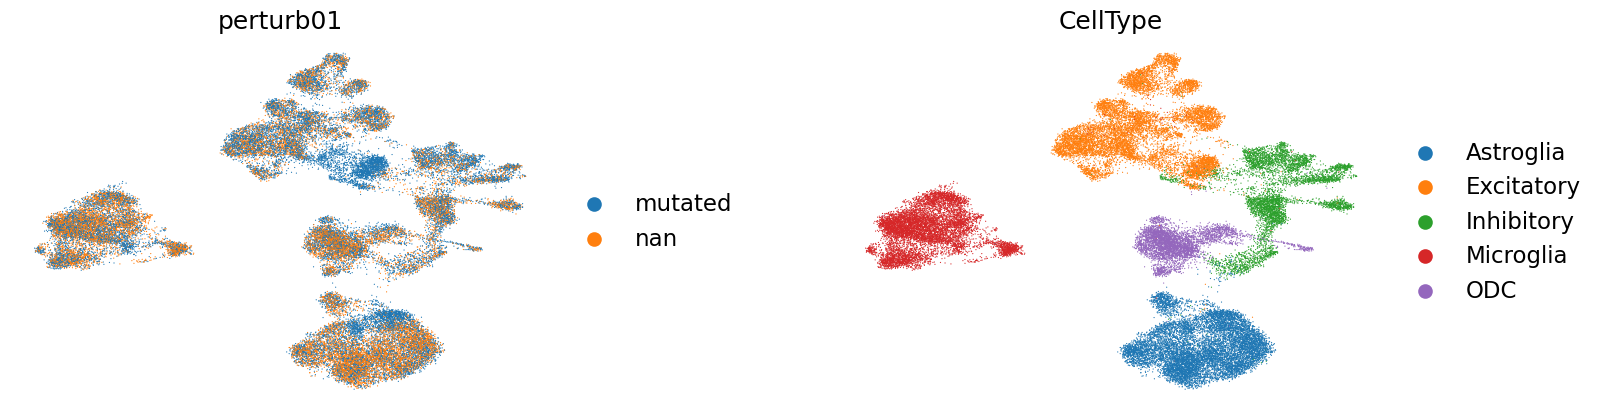

LISI---


cLISI, bLISI, LISI_F1 0.9903790710737541 0.7492344145507099 0.853093045818574


ASW---


asw_label 0.5418268144130707


asw_batch 0.9845631876895367


kBET---


0 labels consist of a single batch or is too small. Skip.


kbet_score 0.712934935726986
graph_conn 0.9992245893742812


NMI, ARI ---
NMI 0.9542955899798473
ARI 0.969365391807504
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.541827  0.969365  0.954296  0.990379  0.749234   0.984563   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.712935            0.999225        0.0  0.992119   

        true pos rate   F1 LISI  
latent       0.820629  0.853093  


In [7]:
def run_scgen(adata, condition_key, cell_type_key,exp_label, ref_label, dataset_name):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    adata=adata.copy()
    
    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]].copy()
    
    pt.tl.Scgen.setup_anndata(adata, batch_key=condition_key, labels_key=cell_type_key)
    scgen_model = pt.tl.Scgen(adata)

    scgen_model.train(
        max_epochs=100,
        batch_size=32,
        early_stopping=True,
        early_stopping_patience=25,
        #accelerator="cpu",
    )

    scgen_model.save("./scgen/"+dataset_name+".pt", overwrite=True)

    latent_X = scgen_model.get_latent_representation()
    latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())
    latent_adata.obsm["latent"]=latent_X

    sc.pp.neighbors(latent_adata)
    sc.tl.umap(latent_adata)
    sc.pl.umap(
        latent_adata,
        color=[condition_key, cell_type_key],
        wspace=0.4,
        frameon=False
    )
    latent_adata.write("./scgen/" + dataset_name + ".h5ad")

    import rpy2.robjects as robjects
    import os
    os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
    import anndata2ri
    anndata2ri.activate()

    from metrics import calculate_metrics

    try:
        calculate_metrics(latent_adata, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='latent', savepath="./scgen/" + dataset_name + ".csv")
    except:
        calculate_metrics(latent_adata, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='latent', savepath="./scgen/" + dataset_name + ".csv")

adata=sc.read_h5ad("../data/ASD1.h5ad")
run_scgen(adata=adata, condition_key='perturb01', cell_type_key="CellType", exp_label='mutated', ref_label='nan', dataset_name="ASD1")

AnnData object with n_obs × n_vars = 40603 × 2000
    obs: 'nGene', 'nUMI', 'Cluster', 'Batch', 'CellType', 'Perturbation', 'isKey', 'isAnalysed', 'SCRUBLET', 'perturb01'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Batch_colors', 'CellType_colors', 'Perturbation_colors', 'hvg', 'neighbors', 'pca', 'perturb01_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


Computing W matrices...


......... Iteration #0

......... Iteration #0

......... Iteration #100

......... Iteration #100

......... Iteration #200

......... Iteration #200

......... Iteration #300

......... Iteration #300

......... Iteration #400

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #0

......... Iteration #100

......... Iteration #100

......... Iteration #200

......... Iteration #200

......... Iteration #300

......... Iteration #300

......... Iteration #400

......... Iteration #400

......... Iteration #499

......... Iteration #499

Orthogonal NMF performed with 500 iterations


Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #0

......... Iteration #100

......... Iteration #100

......... Iteration #200

......... Iteration #200

......... Iteration #300

......... Iteration #300

......... Iteration #400

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #0

......... Iteration #100

......... Iteration #100

......... Iteration #200

......... Iteration #200

......... Iteration #300

......... Iteration #300

......... Iteration #400

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #0

......... Iteration #100

......... Iteration #100

......... Iteration #200

......... Iteration #200

......... Iteration #300

......... Iteration #300

......... Iteration #400

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #0

......... Iteration #100

......... Iteration #100

......... Iteration #200

......... Iteration #200

......... Iteration #300

......... Iteration #300

......... Iteration #400

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #0

......... Iteration #100

......... Iteration #100

......... Iteration #200

......... Iteration #200

......... Iteration #300

......... Iteration #300

......... Iteration #400

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #0

......... Iteration #100

......... Iteration #100

......... Iteration #200

......... Iteration #200

......... Iteration #300

......... Iteration #300

......... Iteration #400

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #0

......... Iteration #100

......... Iteration #100

......... Iteration #200

......... Iteration #200

......... Iteration #300

......... Iteration #300

......... Iteration #400

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #0

......... Iteration #100

......... Iteration #100

......... Iteration #200

......... Iteration #200

......... Iteration #300

......... Iteration #300

......... Iteration #400

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #100

......... Iteration #200

......... Iteration #300

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


......... Iteration #0

......... Iteration #100

......... Iteration #200

......... Iteration #300

......... Iteration #400

......... Iteration #499

Orthogonal NMF performed with 500 iterations


Computing reconstruction errors...


Finding optimal factor number k...


Finish oNMF initialization. See the results in folder:z_ASD1/oNMF


Performing automatic train-test split with 0.2 ratio...


Assigned 0 control cells.
Performing DEG analysis...


Performing leiden clustering...


Finish epoch:4
loss:1.9209597580076203
iteration:635
l2 loss: 0.061232559646912446


Finish epoch:9
loss:1.6465422703525212
iteration:1270
l2 loss: 0.135478436477541


Finish epoch:14
loss:1.4469601432169517
iteration:1905
l2 loss: 0.16181743098056223


Finish epoch:19
loss:1.308705390907648
iteration:2540
l2 loss: 0.16171963923559415


Finish epoch:24
loss:1.2091533968767783
iteration:3175
l2 loss: 0.1487894599127957


Finish epoch:29
loss:1.1459845032278948
iteration:3810
l2 loss: 0.12917559505916956


Finish epoch:34
loss:1.1052639568884541
iteration:4445
l2 loss: 0.10708098377533785


Finish epoch:39
loss:1.079682543521791
iteration:5080
l2 loss: 0.08883624752675455


Finish epoch:44
loss:1.0631898059619693
iteration:5715
l2 loss: 0.07278265047261095


Finish epoch:49
loss:1.0494262608956164
iteration:6350
l2 loss: 0.06095172617379136


Finish epoch:54
loss:1.0403500382355817
iteration:6985
l2 loss: 0.050995933962619214


Finish epoch:59
loss:1.0326648875484317
iteration:7620
l2 loss: 0.0428487527675516


Finish epoch:64
loss:1.023871739079633
iteration:8255
l2 loss: 0.037825629789763546


Finish epoch:69
loss:1.0173406295889005
iteration:8890
l2 loss: 0.033596208832395356


Finish epoch:74
loss:1.009861069401418
iteration:9525
l2 loss: 0.030400458253978743


Finish epoch:79
loss:1.0035579035601279
iteration:10160
l2 loss: 0.027426119468460873


Finish epoch:84
loss:0.997006648638117
iteration:10795
l2 loss: 0.025052284103209577


Finish epoch:89
loss:0.9931918420190886
iteration:11430
l2 loss: 0.022886129110816895


Finish epoch:94
loss:0.9876796786240706
iteration:12065
l2 loss: 0.02058188275500076


Finish epoch:99
loss:0.9850261234861659
iteration:12700
l2 loss: 0.01819676185745423
Training stop at epoch 99
Plotting the loss and metrics...


Calculating the basal state and factor-level expression of each cell...


Checking the mixing performance...
Error occurred during scCAPE training: list.remove(x): x not in list


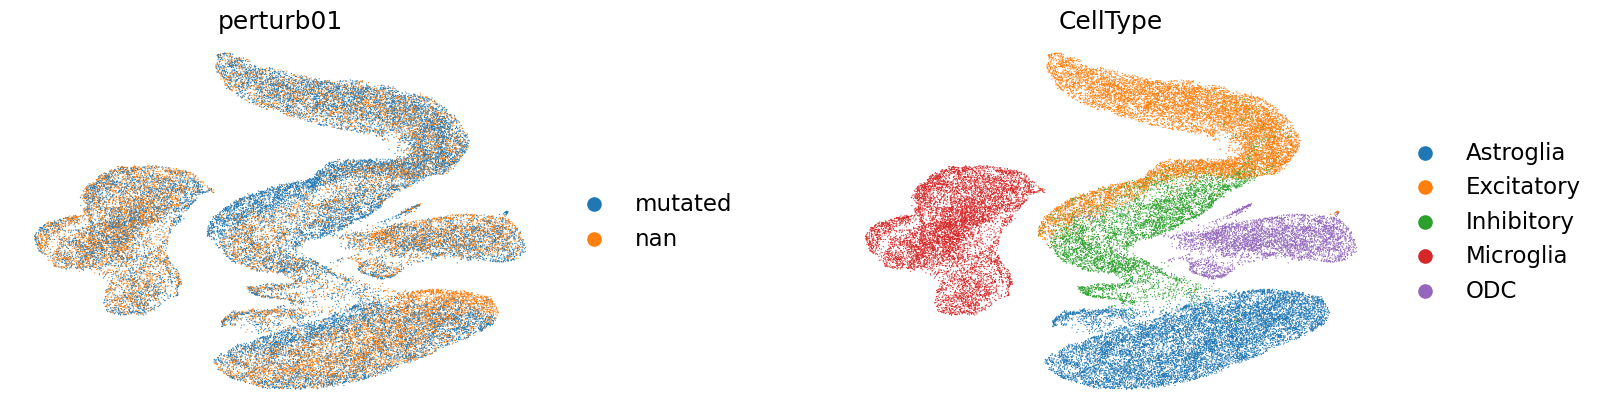

LISI---


cLISI, bLISI, LISI_F1 0.9889615919804233 0.7294122016563603 0.8395852576793839


ASW---


asw_label 0.6602081060409546


asw_batch 0.9247997024862407


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


kbet_score 0.788451536541667
graph_conn 0.9981204585346293


NMI, ARI ---
NMI 0.8527127703204078
ARI 0.8393313867800658
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.660208  0.839331  0.852713  0.988962  0.729412     0.9248   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.788452             0.99812        0.0  0.979435   

        true pos rate   F1 LISI  
latent       0.748344  0.839585  


In [8]:
import os
import multiprocessing
'''
multiprocessing.set_start_method('spawn', force=True)
multiprocessing.set_start_method('forkserver', force=True)
warnings.filterwarnings('ignore', category=DeprecationWarning, module='multiprocessing')

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
'''
def run_sccape(adata, condition_key, cell_type_key, exp_label, ref_label, dataset_name):
    dataset_name1= "z_"+dataset_name

    print(adata)
    if adata.shape[1]>2000:
        sc.pp.highly_variable_genes(adata, n_top_genes=2000)
        adata = adata[:, adata.var["highly_variable"]]
    
    if isinstance(adata.X, scipy.sparse.spmatrix):
        X_dense = adata.X.toarray()
    
    adata.obs["condition"]=adata.obs[condition_key].copy()
    adata.write("./scCAPE/tmp.h5ad")
    
    data_x=csr_matrix(adata.X.T)
    sccape.onmf(data=data_x, dataset_name=dataset_name1, ncells=2000, nfactors=list(range(5, 16)),nreps=2, niters=500)
    
    try:
        sccape.CAPE_train(data_path="./scCAPE/tmp.h5ad", dataset_name=dataset_name1, perturbation_key='condition', split_key=None,
                      max_epochs=300, lambda_adv=0.5, lambda_ort=0.5, patience=5, model_index=0, hparams=None,
                      verbose=True)
    except Exception as e:
        print("Error occurred during scCAPE training:", str(e))


    latent_adata = sc.read_h5ad(os.path.join(dataset_name1, 'CAPE', 'model_index=0_basal.h5ad'))
    latent_adata.obsm["latent"] = latent_adata.X
    latent_adata.obs = adata.obs

    sc.pp.neighbors(latent_adata)
    sc.tl.umap(latent_adata)
    sc.pl.umap(
        latent_adata,
        color=[condition_key, cell_type_key],
        wspace=0.4,
        frameon=False
    )
    latent_adata.write("./scCAPE/" + dataset_name + ".h5ad")

    import rpy2.robjects as robjects
    os.environ["R_HOME"]="/home/xx244/.conda/envs/benchmark/lib/R"
    import anndata2ri
    anndata2ri.activate()

    from metrics import calculate_metrics

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    try:
        calculate_metrics(latent_adata, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='latent', savepath="./scCAPE/" + dataset_name + ".csv")
    except:
        calculate_metrics(latent_adata, batch_key=condition_key, celltype_key=cell_type_key, all=True, n_neighbors=15,
                          embed='latent', savepath="./scCAPE/" + dataset_name + ".csv")

adata=sc.read_h5ad("../data/ASD1.h5ad")
run_sccape(adata=adata, condition_key='perturb01', cell_type_key="CellType", exp_label='mutated', ref_label='nan', dataset_name="ASD1")

In [9]:
def evaluate_ASD1(adata, embed):
    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    print("Evaluating the performance of condition (whether or not perturbed) mixing, phase as cell type")
    # Prepare the environment
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    calculate_metrics(adata, batch_key='Perturbation', celltype_key="CellType", all=True, n_neighbors=15,
                      embed=embed)
    print("="*20)

    print("Evaluating the performance of condition (gene target of CRISPR) mixing, phase as cell type")
    # Prepare the environment
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    calculate_metrics(adata, batch_key='perturb01', celltype_key="CellType", all=True, n_neighbors=15,
                      embed=embed)
    print("=" * 20)

    print("Evaluating the performance of batch mixing, phase as cell type")
    # Prepare the environment
    import rpy2.robjects as robjects
    import anndata2ri
    anndata2ri.activate()
    library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
    robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
    calculate_metrics(adata, batch_key="Batch", celltype_key="CellType", all=True, n_neighbors=15,
                      embed=embed)
    print("=" * 20)

model_names=["cinema_ot","mixscape","scCAPE","scgen"]
embed_names=['cf','ef','latent','latent']
for i in range(len(model_names)):
    model_name=model_names[i]
    print(model_name)
    adata=sc.read_h5ad("./"+model_name+"/ASD1.h5ad")
    evaluate_ASD1(adata, embed_names[i])

cinema_ot


Evaluating the performance of condition (whether or not perturbed) mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9958631497379129 0.05690954725767489 0.1076663958780919


Variance contribution increased after integration!
Setting PCR comparison score to 0.
ASW---


asw_label 0.5506751090288162


asw_batch 0.7374681419400823


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


kbet_score 0.5529944181244671
graph_conn 0.9992355395904038


NMI, ARI ---
NMI 0.9659880003542185
ARI 0.9808844155988334
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI    bLISI  ASW_batch  \
cf   0.550675  0.980884  0.965988  0.995863  0.05691   0.737468   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.552994            0.999236          0  0.991528       0.049873   

     F1 LISI  
cf  0.107666  
Evaluating the performance of condition (gene target of CRISPR) mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9958631497379129 0.1440160741583977 0.25164122341669604


ASW---


asw_label 0.5506751090288162


asw_batch 0.6858293637570642


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


kbet_score 0.4413388869164441
graph_conn 0.9992355395904038


NMI, ARI ---
NMI 0.9659880003542185
ARI 0.9808844155988334
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
cf   0.550675  0.980884  0.965988  0.995863  0.144016   0.685829   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.441339            0.999236   0.851827  0.991528       0.264907   

     F1 LISI  
cf  0.251641  
Evaluating the performance of batch mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9958631497379129 0.20152423640366895 0.33521408883416354


ASW---


asw_label 0.5506751090288162


asw_batch 0.8933843007309749


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 4


kbet_score 0.07442439175784421
graph_conn 0.9992355395904038


NMI, ARI ---
NMI 0.9659880003542185
ARI 0.9808844155988334
positive and true positive rate---


    ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
cf   0.550675  0.980884  0.965988  0.995863  0.201524   0.893384   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
cf          0.074424            0.999236    0.22476  0.991528       0.051105   

     F1 LISI  
cf  0.335214  
mixscape


Evaluating the performance of condition (whether or not perturbed) mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9945344149217002 0.0028798273434187515 0.005743024875117414


Variance contribution increased after integration!
Setting PCR comparison score to 0.
ASW---


asw_label 0.6733586341142654


asw_batch 0.889970566707904


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


kbet_score 0.7009134268087471
graph_conn 0.9994726166291381


NMI, ARI ---
NMI 0.9177980626217841
ARI 0.9002000173247925
positive and true positive rate---


    ASW_label     ARI       NMI   1-cLISI    bLISI  ASW_batch  \
ef   0.673359  0.9002  0.917798  0.994534  0.00288   0.889971   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
ef          0.700913            0.999473          0  0.992143       0.007192   

     F1 LISI  
ef  0.005743  
Evaluating the performance of condition (gene target of CRISPR) mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9945344149217002 0.09613234847651307 0.1753183138161347


Variance contribution increased after integration!
Setting PCR comparison score to 0.
ASW---


asw_label 0.6733586341142654


asw_batch 0.8477484113372904


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 4


kbet_score 0.21215672635176497
graph_conn 0.9994726166291381


NMI, ARI ---
NMI 0.9177980626217841
ARI 0.9002000173247925
positive and true positive rate---


    ASW_label     ARI       NMI   1-cLISI     bLISI  ASW_batch  \
ef   0.673359  0.9002  0.917798  0.994534  0.096132   0.847748   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
ef          0.212157            0.999473          0  0.992143       0.048174   

     F1 LISI  
ef  0.175318  
Evaluating the performance of batch mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9945344149217002 0.19620673240770126 0.32775275845038154


ASW---


asw_label 0.6733586341142654


asw_batch 0.916243704017278


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 4


kbet_score 0.07020626575352762
graph_conn 0.9994726166291381


NMI, ARI ---
NMI 0.9177980626217841
ARI 0.9002000173247925
positive and true positive rate---


    ASW_label     ARI       NMI   1-cLISI     bLISI  ASW_batch  \
ef   0.673359  0.9002  0.917798  0.994534  0.196207   0.916244   

    kBET Accept Rate  graph connectivity  PCR_batch  pos rate  true pos rate  \
ef          0.070206            0.999473   0.018202  0.992143       0.062089   

     F1 LISI  
ef  0.327753  
scCAPE
Evaluating the performance of condition (whether or not perturbed) mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9889615919804233 0.0632192279290413 0.11884152821158177


ASW---


asw_label 0.6602081060409546


asw_batch 0.7641858904959892


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 4


kbet_score 0.6652395322793401
graph_conn 0.9981204585346293


NMI, ARI ---
NMI 0.8527127703204078
ARI 0.8393313867800658
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.660208  0.839331  0.852713  0.988962  0.063219   0.764186   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent           0.66524             0.99812        0.0  0.979435   

        true pos rate   F1 LISI  
latent       0.162845  0.118842  
Evaluating the performance of condition (gene target of CRISPR) mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9889615919804233 0.7294122016563603 0.8395852576793839


ASW---


asw_label 0.6602081060409546


asw_batch 0.9247997024862407


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


kbet_score 0.7906440270281405
graph_conn 0.9981204585346293


NMI, ARI ---
NMI 0.8527127703204078
ARI 0.8393313867800658
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.660208  0.839331  0.852713  0.988962  0.729412     0.9248   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.790644             0.99812        0.0  0.979435   

        true pos rate   F1 LISI  
latent       0.748344  0.839585  
Evaluating the performance of batch mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9889615919804233 0.24749665701727938 0.3959125803593489


ASW---


asw_label 0.6602081060409546


asw_batch 0.8216043740236568


kBET---


0 labels consist of a single batch or is too small. Skip.


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


Adding diffusion to step 4


Adding diffusion to step 5


Adding diffusion to step 6


Adding diffusion to step 4


kbet_score 0.13182120574317224
graph_conn 0.9981204585346293


NMI, ARI ---
NMI 0.8527127703204078
ARI 0.8393313867800658
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.660208  0.839331  0.852713  0.988962  0.247497   0.821604   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.131821             0.99812        0.0  0.979435   

        true pos rate   F1 LISI  
latent       0.099722  0.395913  
scgen


Evaluating the performance of condition (whether or not perturbed) mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9903790710737541 0.06003827869319428 0.11321339026668817


ASW---


asw_label 0.5418268144130707


asw_batch 0.9516133463282616


kBET---


0 labels consist of a single batch or is too small. Skip.


kbet_score 0.5596132589696211
graph_conn 0.9992245893742812


NMI, ARI ---
NMI 0.9542955899798473
ARI 0.969365391807504
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.541827  0.969365  0.954296  0.990379  0.060038   0.951613   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.559613            0.999225        0.0  0.992119   

        true pos rate   F1 LISI  
latent       0.199468  0.113213  
Evaluating the performance of condition (gene target of CRISPR) mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9903790710737541 0.7492344145507099 0.853093045818574


ASW---


asw_label 0.5418268144130707


asw_batch 0.9845631876895367


kBET---


0 labels consist of a single batch or is too small. Skip.


kbet_score 0.7118151181731935
graph_conn 0.9992245893742812


NMI, ARI ---
NMI 0.9542955899798473
ARI 0.969365391807504
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.541827  0.969365  0.954296  0.990379  0.749234   0.984563   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.711815            0.999225        0.0  0.992119   

        true pos rate   F1 LISI  
latent       0.820629  0.853093  
Evaluating the performance of batch mixing, phase as cell type
LISI---


cLISI, bLISI, LISI_F1 0.9903790710737541 0.2033406620499707 0.33740639516042814


ASW---


asw_label 0.5418268144130707


asw_batch 0.9701070332468842


kBET---


0 labels consist of a single batch or is too small. Skip.


kbet_score 0.10324249707439515
graph_conn 0.9992245893742812


NMI, ARI ---
NMI 0.9542955899798473
ARI 0.969365391807504
positive and true positive rate---


        ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
latent   0.541827  0.969365  0.954296  0.990379  0.203341   0.970107   

        kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
latent          0.103242            0.999225        0.0  0.992119   

        true pos rate   F1 LISI  
latent        0.07795  0.337406  
